# Menu Database Analysis and Report
### For Analytics, we should use the menu_cstore database
Because column store is optimized to run ad hoc queries on billions of rows without indexes,
combining columnar data on low-cost object storage with multi-threaded query processing
which is perfect for cloud data warehousing/analytics.

In [1]:
import pandas as pd
from IPython.display import display
import mysql.connector

In [2]:
# Functions that used to connect with the cloud database and display results.
def create_connection():
    conn = None
    try:
       conn = mysql.connector.connect(
          user="DB0000xxxx",
          password="xxxxxxxxxxxxxxxxxxxxx",
          host="menu-data-db.mdb0002067.db.skysql.net",
          ssl_ca="skysql_chain.pem",
          port=5001)
       conn.autocommit = False
       print('Database server connected!')
       return conn
    except mysql.connector.Error as e:
       print(f"Error connecting to MariaDB Platform: {e}")
    return conn

def sql_execute(conn, sql):

    try:
        cur = conn.cursor()
        cur.execute(sql, multi=True)
        conn.commit()
    except mysql.connector.Error as e:
        print(e)

def sql_execute_show(conn, sql):

    try:
        df = pd.read_sql(sql, con = conn)
        return df
    except mysql.connector.Error as e:
        print(e)

# Querying Example
- Only call the create_connection() function once
- Use the sql_execute_show() function to display results in python
- Remember to close connection at the end of your session

In [3]:
# Only call once
conn = create_connection()

Database server connected!


In [11]:
# sql_execute_show() conn parameter = conn
# sql parameter = the string of you SQL query
sql_execute_show(conn, sql = '''
SELECT * FROM menu_cstore.food_category
;
''')

,cat_id,cat_name
0,0,Appetizers & Sides
1,1,Baked Goods
2,2,Beverages
3,3,Burgers
4,4,Desserts
5,5,Entrees
6,6,Fried Potatoes
7,7,Pizza
8,8,Salads
9,9,Sandwiches


In [7]:
sql_execute_show(conn, sql = '''
SELECT b.r_name, AVG(calories), AVG(total_fat), AVG(Protein)
FROM menu_cstore.nutrition_facts a
LEFT JOIN menu_cstore.restaurant b ON a.r_id = b.r_id
GROUP BY b.r_name
;
''')

,r_name,AVG(calories),AVG(total_fat),AVG(Protein)
0,None,459.4577,24.4788,17.7381
1,7 Eleven,289.9115,14.1728,9.8063
2,Applebee's,535.8140,29.0960,23.8558
3,Arby's,347.4370,15.9087,13.2212
4,Auntie Anne's,275.5607,5.2865,4.4921
...,...,...,...,...
92,Whataburger,434.8670,18.6071,13.5658
93,White Castle,378.2370,13.7935,8.1544
94,Wingstop,220.3913,11.6316,12.3684
95,Yard House,697.2137,40.0058,30.8827


In [17]:
conn.close()


# MariaDB ROLLUP Syntax Example
Reference: https://mariadb.com/kb/en/select-with-rollup/

**For each restaurant in the Entrées category,
perform a ROLLUP query, then use pandas pivot function to generate a nicer table**


In [9]:
df_rollup = sql_execute_show(conn, sql = '''
SELECT
    COALESCE(b.r_name, "All Restaurants") AS "Restaurant",
    COALESCE(year, "All Years") AS "Year",
    AVG(calories), AVG(total_fat), AVG(Protein)
FROM menu_cstore.nutrition_facts a
LEFT JOIN menu_cstore.restaurant b ON a.r_id = b.r_id
WHERE b.r_name != "None" AND a.cat_id = 5
GROUP BY b.r_name, year WITH ROLLUP
;
''')
df_rollup

,Restaurant,Year,AVG(calories),AVG(total_fat),AVG(Protein)
0,7 Eleven,2013,212.5000,9.6250,8.3750
1,7 Eleven,2014,213.3333,7.7778,8.2222
2,7 Eleven,2015,217.2727,8.5455,9.0909
3,7 Eleven,2016,210.0000,9.6667,14.0000
4,7 Eleven,2017,NaN,NaN,NaN
...,...,...,...,...,...
715,Zaxby's,2016,950.1818,53.7727,72.9091
716,Zaxby's,2017,957.0000,55.5789,68.3684
717,Zaxby's,2018,1085.5660,52.9811,89.4906
718,Zaxby's,All Years,974.4121,67.8794,77.1709


**For the average calories for each restaurant in the Entrées category over the years**

In [8]:
df_rollup.pivot(index=["Restaurant"], columns="Year", values="AVG(calories)")

Year,2008,2010,2012,2013,2014,2015,2016,2017,2018,All Years
Restaurant,,,,,,,,,,
7 Eleven,NaN,NaN,NaN,212.5000,213.3333,217.2727,210.0000,NaN,NaN,214.1935
All Restaurants,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,674.8127
Applebee's,345.0000,NaN,888.6207,831.2069,767.9104,956.4935,755.2941,742.5532,781.9565,822.5980
Arby's,387.2857,414.0000,345.0000,335.0000,390.0000,390.0000,400.0000,387.5000,505.7143,403.2750
BJ's Restaurant & Brewhouse,NaN,NaN,NaN,NaN,NaN,852.9091,855.3061,821.2500,826.8056,838.2589
...,...,...,...,...,...,...,...,...,...,...
Whataburger,617.7778,590.5556,565.5556,684.1379,684.8276,659.0909,647.9412,656.1538,665.3659,649.7297
White Castle,NaN,NaN,460.0000,460.0000,230.0000,367.1429,1284.0000,1284.0000,280.0000,874.2857
Wingstop,NaN,NaN,NaN,NaN,NaN,NaN,278.9333,278.9333,278.9333,278.9333


**For the average protein for each restaurant in the Entrées category over the years**

In [9]:
#df_rollup.pivot(index=["r_name"], columns="year", values="AVG(Protein)")

**For the average total_fat for each restaurant in the Entrées category over the years**

In [10]:
#df_rollup.pivot(index=["r_name"], columns="year", values="AVG(total_fat)")

In [4]:
avg_calories = sql_execute_show(conn, sql = '''
SELECT year, b.r_name, AVG(calories) AS avg_calories
FROM menu_cstore.nutrition_facts a
LEFT JOIN menu_cstore.restaurant b ON a.r_id = b.r_id
WHERE r_name = '7 Eleven'
GROUP BY b.r_name, year
;
''')
avg_calories

,year,r_name,avg_calories
0,2013,7 Eleven,284.1429
1,2014,7 Eleven,301.5238
2,2015,7 Eleven,287.8980
3,2016,7 Eleven,303.2778
4,2017,7 Eleven,308.2353
5,2018,7 Eleven,133.3333


## We can also add the food_category in the GROUP BY clause, to make it a three dimensional cube

In [19]:
df_rollup2 = sql_execute_show(conn, sql = '''
SELECT
    COALESCE(year, "All Years") AS "Year",
    COALESCE(b.r_name, "All Restaurants") AS "Restaurant",
    COALESCE(c.cat_name, "All Categories") AS "Category",
    AVG(calories)#, AVG(total_fat), AVG(Protein)
FROM menu_cstore.nutrition_facts a
LEFT JOIN menu_cstore.restaurant b ON a.r_id = b.r_id
LEFT JOIN menu_cstore.food_category c ON a.cat_id = c.cat_id
WHERE r_name != "None" AND calories != "None" AND year > 2012
GROUP BY b.r_name, c.cat_name, year WITH ROLLUP
;
''')
display(df_rollup2)
df_rollup2.pivot(index=["Restaurant", "Category"], columns="Year", values="AVG(calories)").head(23)

,Year,Restaurant,Category,AVG(calories)
0,2013,7 Eleven,Appetizers & Sides,66.6667
1,2014,7 Eleven,Appetizers & Sides,80.0000
2,2015,7 Eleven,Appetizers & Sides,85.0000
3,2016,7 Eleven,Appetizers & Sides,80.0000
4,All Years,7 Eleven,Appetizers & Sides,75.7143
...,...,...,...,...
5664,2017,Zaxby's,Toppings & Ingredients,157.9730
5665,2018,Zaxby's,Toppings & Ingredients,172.7941
5666,All Years,Zaxby's,Toppings & Ingredients,164.0440
5667,All Years,Zaxby's,All Categories,487.2280


Year                                        2013      2014      2015  \
Restaurant      Category                                               
7 Eleven        All Categories               NaN       NaN       NaN   
                Appetizers & Sides       66.6667   80.0000   85.0000   
                Beverages                99.0000  103.4286  101.0000   
                Burgers                 440.0000  440.0000  440.0000   
                Entrees                 212.5000  213.3333  217.2727   
                Fried Potatoes          186.6667  170.0000  170.0000   
                Pizza                   300.0000  435.0000  435.0000   
                Salads                       NaN  210.0000  225.0000   
                Sandwiches              407.0000  425.2632  414.5000   
All Restaurants All Categories               NaN       NaN       NaN   
Applebee's      All Categories               NaN       NaN       NaN   
                Appetizers & Sides      668.4524  626.2500  546.5152   
                Baked Goods             315.0000  315.0000  315.0000   
                Beverages               157.1429  261.7647  230.2381   
                Burgers                 949.3750  946.8750  985.3333   
                Desserts                703.0769  821.0000  709.3333   
                Entrees                 831.2069  767.9104  956.4935   
                Fried Potatoes          515.0000  670.0000  648.3333   
                Pizza                   490.0000  460.0000  450.0000   
                Salads                  588.0488  576.9444  584.5161   
                Sandwiches              740.5000  748.2353  697.0588   
                Soup                    294.7619  319.4118  298.0000   
                Toppings & Ingredients  170.9375  147.0000  245.5769   

Year                                        2016      2017      2018  \
Restaurant      Category                                               
7 Eleven        All Categories               NaN       NaN       NaN   
                Appetizers & Sides       80.0000       NaN       NaN   
                Beverages               130.6667  180.0000  100.0000   
                Burgers                      NaN       NaN       NaN   
                Entrees                 210.0000       NaN       NaN   
                Fried Potatoes          240.0000       NaN       NaN   
                Pizza                        NaN       NaN       NaN   
                Salads                  330.0000  230.0000       NaN   
                Sandwiches              455.2941  518.3333  300.0000   
All Restaurants All Categories               NaN       NaN       NaN   
Applebee's      All Categories               NaN       NaN       NaN   
                Appetizers & Sides      414.3750  567.0000  556.8750   
                Baked Goods                  NaN       NaN       NaN   
                Beverages               192.6984  233.3019  207.9327   
                Burgers                 910.0000  846.0000  852.7273   
                Desserts                805.0000  835.0000  842.2222   
                Entrees                 755.2941  742.5532  781.9565   
                Fried Potatoes          584.0000  560.0000  420.0000   
                Pizza                   455.0000       NaN       NaN   
                Salads                  556.6667  733.5294  697.7778   
                Sandwiches              778.6667  716.3636  733.8462   
                Soup                    330.0000  251.4286  261.4286   
                Toppings & Ingredients  159.8214  168.7879  176.2162   

Year                                    All Years  
Restaurant      Category                           
7 Eleven        All Categories           289.9115  
                Appetizers & Sides        75.7143  
                Beverages                122.9556  
                Burgers                  440.0000  
                Entrees                  214.1935  
                Fried Potatoes    

# Analysis

In [13]:
df_rollup3 = sql_execute_show(conn, sql = '''
SELECT
    COALESCE(year, "All Years") AS "Year",
    #COALESCE(b.r_name, "All Restaurants") AS "Restaurant",
    COALESCE(c.cat_name, "All Categories") AS "Category",
    AVG(calories), AVG(total_fat), AVG(Protein)
FROM menu_cstore.nutrition_facts a
LEFT JOIN menu_cstore.restaurant b ON a.r_id = b.r_id
LEFT JOIN menu_cstore.food_category c ON a.cat_id = c.cat_id
WHERE r_name != "None" AND cat_name != "None" AND year > 2012
GROUP BY c.cat_name, year WITH ROLLUP
;
''')
df_rollup3

,Year,Category,AVG(calories),AVG(total_fat),AVG(Protein)
0,2013,Appetizers & Sides,396.6580,23.0072,16.7213
1,2014,Appetizers & Sides,390.1641,22.5220,15.6779
2,2015,Appetizers & Sides,491.0376,28.4265,20.4415
3,2016,Appetizers & Sides,501.1953,29.5176,22.0809
4,2017,Appetizers & Sides,524.1933,30.7890,24.0568
...,...,...,...,...,...
80,2016,Toppings & Ingredients,126.9228,6.7788,4.3296
81,2017,Toppings & Ingredients,108.2308,6.5536,4.0617
82,2018,Toppings & Ingredients,117.9189,6.8021,4.5814
83,All Years,Toppings & Ingredients,119.2069,6.9528,4.3336


In [14]:
df_rollup3.pivot(index=["Category"], columns="Year", values="AVG(calories)")


Year,2013,2014,2015,2016,2017,2018,All Years
Category,,,,,,,
All Categories,NaN,NaN,NaN,NaN,NaN,NaN,381.9768
Appetizers & Sides,396.6580,390.1641,491.0376,501.1953,524.1933,492.3893,474.9805
Baked Goods,321.9156,323.0033,341.7546,325.8384,314.3300,325.2595,325.4517
Beverages,271.7302,292.5806,286.9508,266.7975,281.0422,260.0319,276.0245
Burgers,717.0741,738.2198,745.1322,760.2667,769.6020,767.3328,750.9502
Desserts,532.2527,528.6543,529.2785,527.9065,551.0086,566.6953,538.8543
Entrees,667.5194,646.5769,713.7800,690.4917,664.3179,696.8117,681.9049
Fried Potatoes,476.6102,469.4983,477.0657,488.2281,499.6524,477.2965,482.0797
Pizza,360.9595,385.1775,382.4221,368.8720,373.5861,354.5525,369.9036


In [22]:
import seaborn as sns



# Avg Nutrients in All Categories

,year,cat_name,AVG(calories)
0,2013,Appetizers & Sides,396.6580
1,2014,Appetizers & Sides,390.1641
2,2015,Appetizers & Sides,491.0376
3,2016,Appetizers & Sides,501.1953
4,2017,Appetizers & Sides,524.1933
...,...,...,...
67,2014,Toppings & Ingredients,117.4454
68,2015,Toppings & Ingredients,126.1500
69,2016,Toppings & Ingredients,126.9228
70,2017,Toppings & Ingredients,108.2308


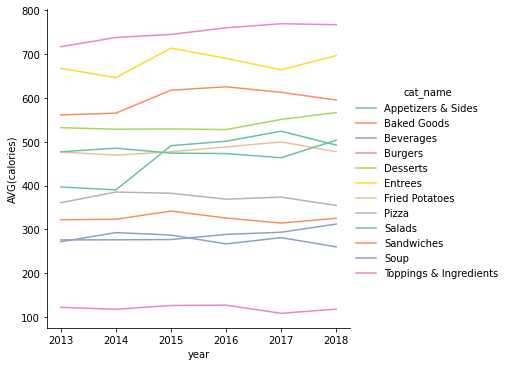

In [156]:
df_cal = sql_execute_show(conn, sql = '''
SELECT a.year, c.cat_name, AVG(calories)
FROM menu_cstore.nutrition_facts a
LEFT JOIN menu_cstore.restaurant b ON a.r_id = b.r_id
LEFT JOIN menu_cstore.food_category c ON a.cat_id = c.cat_id
WHERE year > 2012 AND calories IS NOT NULL
GROUP BY c.cat_name , year
''')
sns.relplot(data=df_cal, x='year', y='AVG(calories)', hue='cat_name', kind='line', palette="Set2")

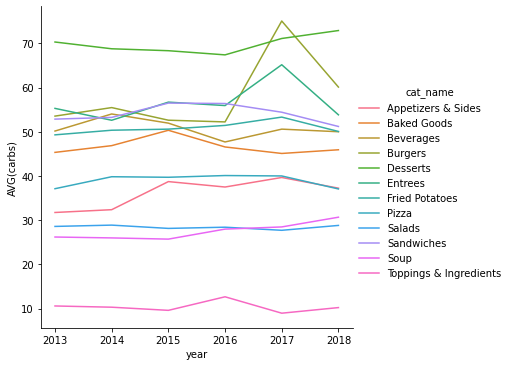

In [27]:
df_cal = sql_execute_show(conn, sql = '''
SELECT a.year, c.cat_name, AVG(carbs)
FROM menu_cstore.nutrition_facts a
LEFT JOIN menu_cstore.restaurant b ON a.r_id = b.r_id
LEFT JOIN menu_cstore.food_category c ON a.cat_id = c.cat_id
WHERE year > 2012 AND carbs IS NOT NULL
GROUP BY c.cat_name , year
''')
sns.relplot(data=df_cal, x='year', y='AVG(carbs)', hue='cat_name', kind='line')

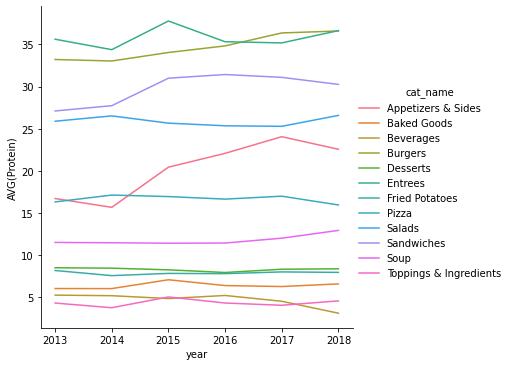

In [24]:
df_cal = sql_execute_show(conn, sql = '''
SELECT a.year, c.cat_name, AVG(Protein)
FROM menu_cstore.nutrition_facts a
LEFT JOIN menu_cstore.restaurant b ON a.r_id = b.r_id
LEFT JOIN menu_cstore.food_category c ON a.cat_id = c.cat_id
WHERE year > 2012 AND Protein IS NOT NULL
GROUP BY c.cat_name , year
''')
sns.relplot(data=df_cal, x='year', y='AVG(Protein)', hue='cat_name', kind='line')

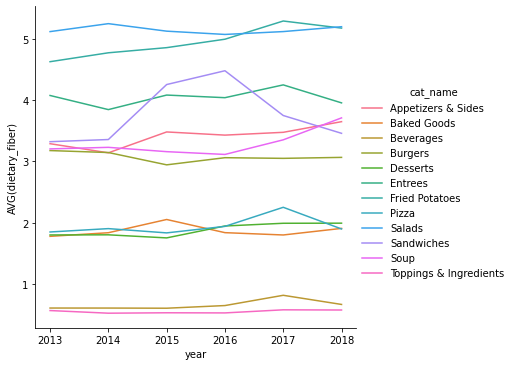

In [25]:
df_cal = sql_execute_show(conn, sql = '''
SELECT a.year, c.cat_name, AVG(dietary_fiber)
FROM menu_cstore.nutrition_facts a
LEFT JOIN menu_cstore.restaurant b ON a.r_id = b.r_id
LEFT JOIN menu_cstore.food_category c ON a.cat_id = c.cat_id
WHERE year > 2012 AND dietary_fiber IS NOT NULL
GROUP BY c.cat_name , year
''')
sns.relplot(data=df_cal, x='year', y='AVG(dietary_fiber)', hue='cat_name', kind='line')

## Cholesterol intake limit
The official advice from the American Heart Association and other groups is to limit your total daily intake to
less than 300 milligrams. But while checking cholesterol numbers, also take a look at the saturated fat,
which has a much bigger impact on raising cholesterol levels.
https://www.webmd.com/food-recipes/features/cholesterol-food

In [57]:
df_ts = sql_execute_show(conn, sql = '''
SELECT a.year, b.r_name, c.cat_name, AVG(calories), AVG(cholesterol), AVG(trans_fat),
    AVG(Protein), AVG(carbs)
FROM menu_cstore.nutrition_facts a
LEFT JOIN menu_cstore.restaurant b ON a.r_id = b.r_id
LEFT JOIN menu_cstore.food_category c ON a.cat_id = c.cat_id
WHERE year = 2013 AND cholesterol IS NOT NULL
GROUP BY b.r_name, c.cat_name , year
HAVING AVG(cholesterol) > 200
ORDER BY AVG(cholesterol) DESC
;
''')
df_ts

,year,r_name,cat_name,AVG(calories),AVG(cholesterol),AVG(trans_fat),AVG(Protein),AVG(carbs)
0,2013,Culver's,Entrees,1943.0000,479.9412,2.0588,135.0000,102.1765
1,2013,Checker's Drive-In/Rallys,Appetizers & Sides,1409.7619,437.8571,0.0000,138.6667,30.2857
2,2013,IHOP,Entrees,880.3302,379.4575,0.8208,35.0283,76.9670
3,2013,Perkins,Entrees,1046.1475,316.7951,0.0492,37.9016,115.6393
4,2013,Krystal,Entrees,449.4444,282.7778,0.5333,17.7222,31.8889
5,2013,Whataburger,Entrees,684.1379,263.7931,0.0000,23.7586,83.5714
6,2013,Dominos,Appetizers & Sides,475.5556,258.6364,0.1818,40.6667,9.2222
7,2013,Bojangles,Entrees,1485.4762,247.4762,0.5238,74.1429,104.7143
8,2013,Perkins,Burgers,1138.0000,245.5000,0.0000,46.6000,80.8000
9,2013,California Pizza Kitchen,Desserts,880.0000,245.1000,0.5000,9.2000,82.0000


# Trend analysis by category

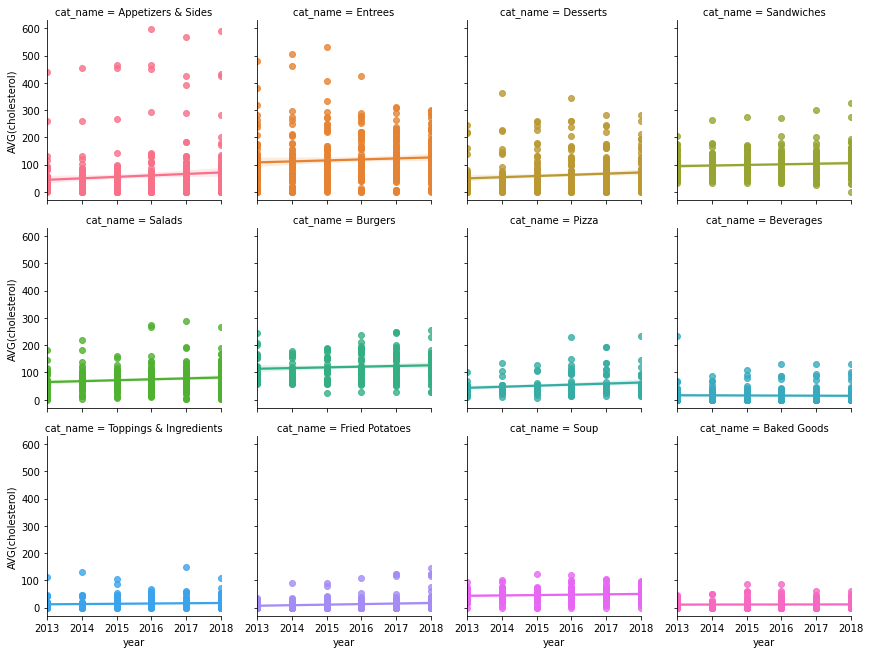

In [5]:
import seaborn as sns
df_ts = sql_execute_show(conn, sql = '''
SELECT a.year, b.r_name, c.cat_name, AVG(calories), AVG(cholesterol), AVG(trans_fat),
    AVG(Protein), AVG(carbs)
FROM menu_cstore.nutrition_facts a
LEFT JOIN menu_cstore.restaurant b ON a.r_id = b.r_id
LEFT JOIN menu_cstore.food_category c ON a.cat_id = c.cat_id
WHERE year > 2012 AND cholesterol IS NOT NULL
GROUP BY b.r_name, c.cat_name , year
#HAVING AVG(cholesterol) > 200
ORDER BY AVG(cholesterol) DESC
;
''')


sns.lmplot(x="year", y="AVG(cholesterol)", col="cat_name", hue="cat_name",
               data=df_ts.dropna(), col_wrap=4, height=3)

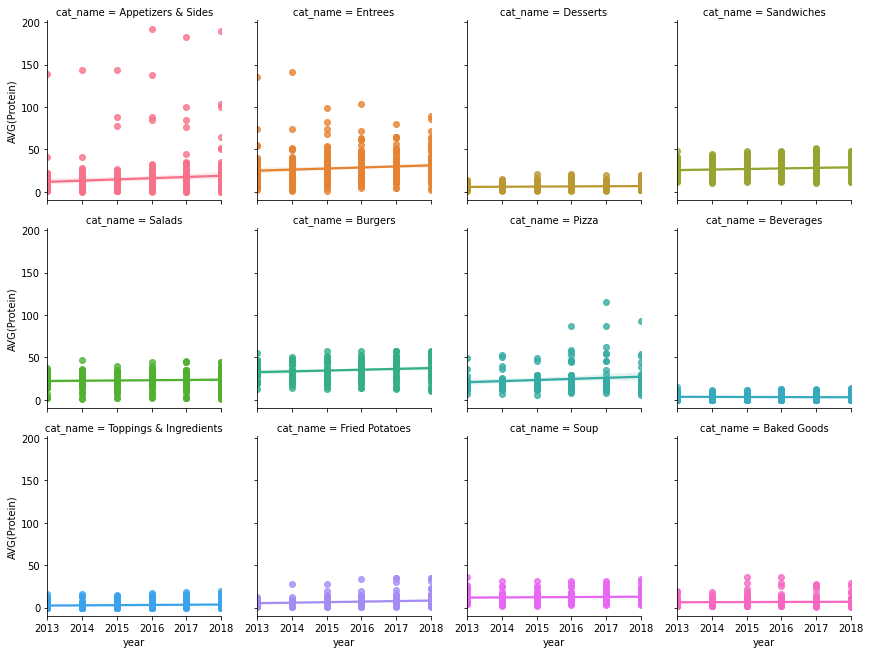

In [175]:
sns.lmplot(x="year", y="AVG(Protein)", col="cat_name", hue="cat_name",
               data=df_ts.dropna(), col_wrap=4, height=3)

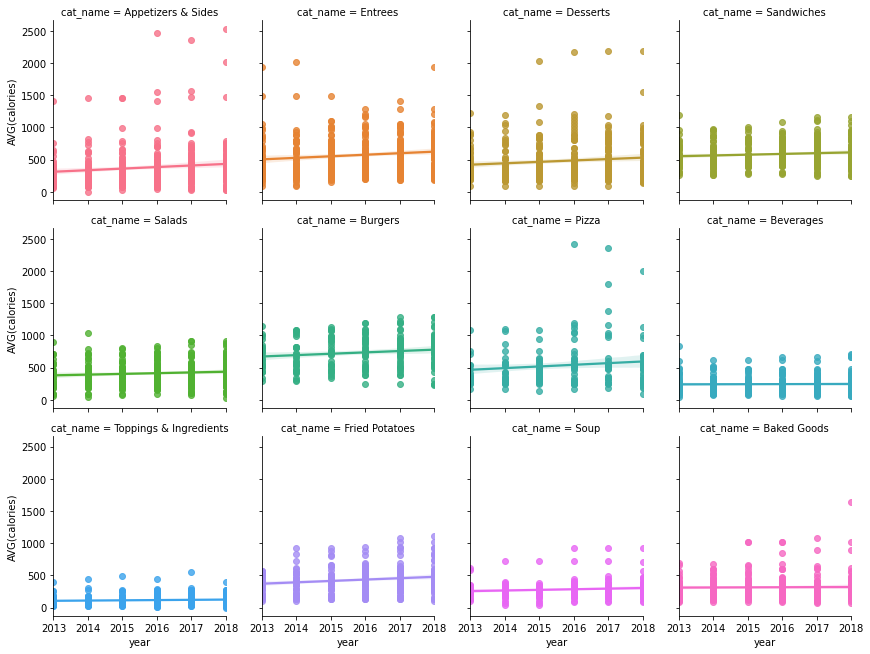

In [116]:
sns.lmplot(x="year", y="AVG(calories)", col="cat_name", hue="cat_name",
               data=df_ts.dropna(), col_wrap=4, height=3)

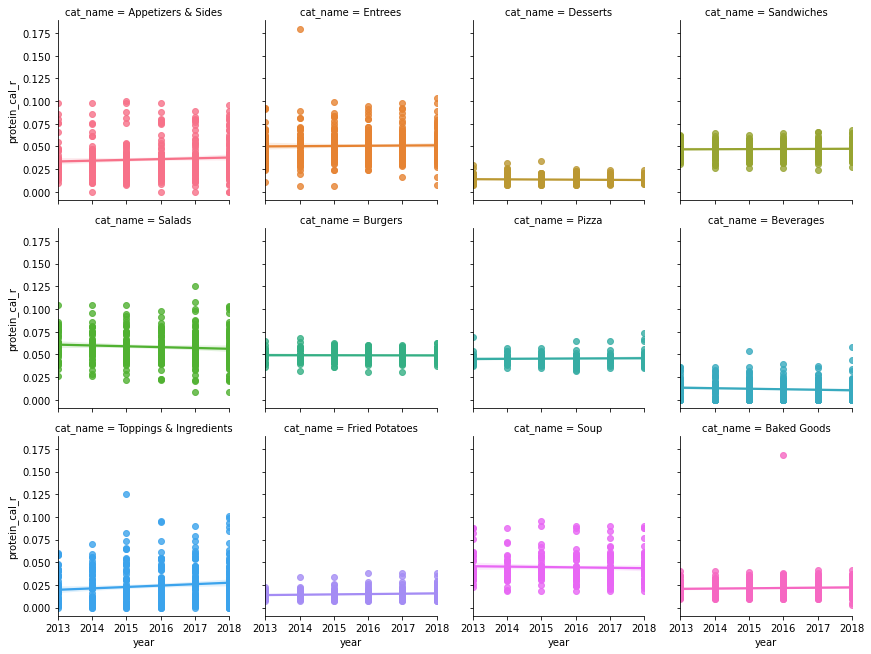

In [61]:
df_ts = sql_execute_show(conn, sql = '''
SELECT a.year, b.r_name, c.cat_name, AVG(calories), AVG(cholesterol), AVG(trans_fat)/AVG(calories) AS tfat_cal_r,
    AVG(Protein)/AVG(calories) AS protein_cal_r, AVG(carbs)/AVG(calories) AS carb_cal_r
FROM menu_cstore.nutrition_facts a
LEFT JOIN menu_cstore.restaurant b ON a.r_id = b.r_id
LEFT JOIN menu_cstore.food_category c ON a.cat_id = c.cat_id
WHERE year > 2012
GROUP BY b.r_name, c.cat_name , year
#HAVING AVG(cholesterol) > 200
ORDER BY AVG(cholesterol) DESC
;
''')

# Protein/Calories Ratio
g = sns.lmplot(x="year", y="protein_cal_r", col="cat_name", hue="cat_name",
        data=df_ts.dropna(), col_wrap=4, height=3)

# Correlation Heatmap

In [46]:
df_rollup3 = sql_execute_show(conn, sql = '''
SELECT
    COALESCE(year, "All Years") AS "Year",
    COALESCE(b.r_name, "All Restaurants") AS "Restaurant",
    COALESCE(c.cat_name, "All Categories") AS "Category",
    AVG(calories), AVG(total_fat), AVG(trans_fat), AVG(cholesterol),
    AVG(sodium), AVG(potassium), AVG(sugar),
    AVG(Protein), AVG(carbs), AVG(dietary_fiber)
FROM menu_cstore.nutrition_facts a
LEFT JOIN menu_cstore.restaurant b ON a.r_id = b.r_id
LEFT JOIN menu_cstore.food_category c ON a.cat_id = c.cat_id
WHERE r_name != "None" AND cat_name != "None" AND year > 2012
GROUP BY b.r_name, c.cat_name, year
;
''')
df_rollup3



,Year,Restaurant,Category,AVG(calories),AVG(total_fat),AVG(trans_fat),AVG(cholesterol),AVG(sodium),AVG(potassium),AVG(sugar),AVG(Protein),AVG(carbs),AVG(dietary_fiber)
0,2013,7 Eleven,Appetizers & Sides,66.6667,2.3333,0.0000,15.0000,370.0000,NaN,0.0000,5.3333,5.6667,0.0000
1,2014,7 Eleven,Appetizers & Sides,80.0000,4.0000,0.0000,25.0000,480.0000,NaN,0.0000,6.0000,3.0000,0.0000
2,2015,7 Eleven,Appetizers & Sides,85.0000,5.0000,0.0000,17.5000,375.0000,NaN,0.0000,4.5000,4.5000,0.5000
3,2016,7 Eleven,Appetizers & Sides,80.0000,4.0000,0.0000,25.0000,480.0000,NaN,0.0000,6.0000,3.0000,0.0000
4,2017,7 Eleven,Appetizers & Sides,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4855,2014,Zaxby's,Toppings & Ingredients,166.6438,11.8493,NaN,16.2603,369.1370,NaN,7.0548,3.0274,12.1644,0.4932
4856,2015,Zaxby's,Toppings & Ingredients,155.5195,10.9091,NaN,14.0390,370.2727,NaN,6.1558,3.0519,11.5584,0.5195
4857,2016,Zaxby's,Toppings & Ingredients,151.8182,10.5714,NaN,15.1429,365.5195,NaN,5.6234,3.3896,11.0260,0.5584
4858,2017,Zaxby's,Toppings & Ingredients,151.8182,10.5714,NaN,15.1429,365.5195,NaN,5.6234,3.3896,11.0260,0.5584


In [42]:
df_rollup3.corr()


,AVG(calories),AVG(total_fat),AVG(Protein),AVG(carbs),AVG(trans_fat),AVG(dietary_fiber)
AVG(calories),1.000000,0.939222,0.797342,0.720316,0.167849,0.531896
AVG(total_fat),0.939222,1.000000,0.789403,0.537705,0.180374,0.485167
AVG(Protein),0.797342,0.789403,1.000000,0.342813,0.142081,0.427598
AVG(carbs),0.720316,0.537705,0.342813,1.000000,0.102707,0.416929
AVG(trans_fat),0.167849,0.180374,0.142081,0.102707,1.000000,0.069301
AVG(dietary_fiber),0.531896,0.485167,0.427598,0.416929,0.069301,1.000000


[Text(0.5, 0, 'AVG(calories)'),
 Text(1.5, 0, 'AVG(total_fat)'),
 Text(2.5, 0, 'AVG(trans_fat)'),
 Text(3.5, 0, 'AVG(cholesterol)'),
 Text(4.5, 0, 'AVG(sodium)'),
 Text(5.5, 0, 'AVG(potassium)'),
 Text(6.5, 0, 'AVG(sugar)'),
 Text(7.5, 0, 'AVG(Protein)'),
 Text(8.5, 0, 'AVG(carbs)'),
 Text(9.5, 0, 'AVG(dietary_fiber)')]

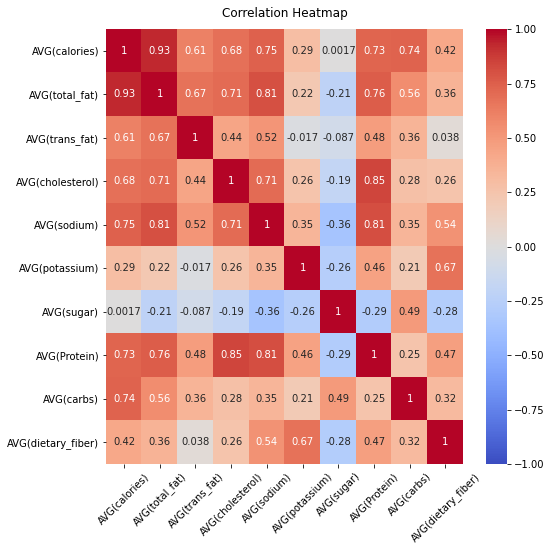

In [53]:
import matplotlib
fig, ax = matplotlib.pyplot.subplots(figsize=(8,8))
heatmap = sns.heatmap(df_rollup3.dropna().corr(), vmin=-1, vmax=1, annot=True, cmap="coolwarm", ax=ax)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45)



